**1. Text Preprocessing, Tokenization, and Sequence Padding**

1.1 Load the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os  # to handle file paths1
import pandas as pd  # for data loading and manipulation
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for enhanced visualizations
import nltk  # for text processing

# ensure nltk packages are available
nltk.download('stopwords')  # download stopwords
nltk.download('punkt_tab')  # download tokenizer
nltk.download('wordnet')  # download lemmatizer data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# load dataset from google drive path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/NewsCategoryDataset/news_category.csv'  # dataset file path
df = pd.read_csv(dataset_path)  # read csv into dataframe

In [4]:
# show first and last records
print("\nhead of dataset:")  # describe head
print(df.head())  # first 5 rows
print("\ntail of dataset:")  # describe tail
print(df.tail())  # last 5 rows


head of dataset:
                                            headline        category
0  How A New Documentary Captures The Complexity ...  CULTURE & ARTS
1  Twitch Bans Gambling Sites After Streamer Scam...            TECH
2  'Reboot' Is A Clever And Not Too Navel-Gazey L...  CULTURE & ARTS
3  Maury Wills, Base-Stealing Shortstop For Dodge...          SPORTS
4  Las Vegas Aces Win First WNBA Title, Chelsea G...          SPORTS

tail of dataset:
                                                headline category
11020  RIM CEO Thorsten Heins' 'Significant' Plans Fo...     TECH
11021  Maria Sharapova Stunned By Victoria Azarenka I...   SPORTS
11022  Giants Over Patriots, Jets Over Colts Among  M...   SPORTS
11023  Aldon Smith Arrested: 49ers Linebacker Busted ...   SPORTS
11024  Dwight Howard Rips Teammates After Magic Loss ...   SPORTS


In [5]:
# check for missing values
print("null values per column:\n", df.isnull().sum())  # display null counts

null values per column:
 headline    0
category    0
dtype: int64


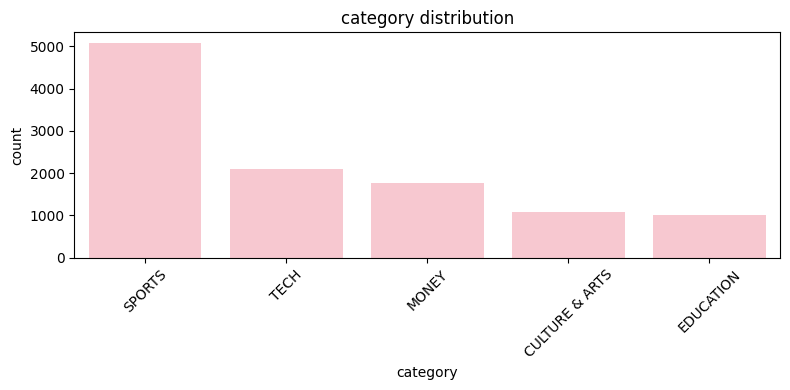

In [6]:
# visualize category distribution
plt.figure(figsize=(8,4))  # set figure size
sns.countplot(x='category', data=df, order=df['category'].value_counts().index,color='#FFC0CB')  # bar plot categories
plt.title('category distribution')  # set title
plt.xticks(rotation=45)  # rotate x labels
plt.tight_layout()  # adjust layout
plt.show()  # display plot

1.2.  Clean the text

In [7]:
import re  # for regex operations
from nltk.corpus import stopwords  # import stopwords
from nltk.stem import WordNetLemmatizer  # import lemmatizer

In [8]:
stop_words = set(stopwords.words('english'))  # set of english stopwords
doc_lemmatizer = WordNetLemmatizer()  # initialize lemmatizer

# define cleaning function
def preprocess_text(text):  # function to clean text
    text = text.lower()  # convert to lowercase
    text = re.sub(r'http\S+', '', text)  # remove urls
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-letters
    tokens = nltk.word_tokenize(text)  # tokenize text
    tokens = [doc_lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]  # lemmatize & remove stopwords
    return ' '.join(tokens)  # join tokens


In [9]:
# apply preprocessing
df['cleaned_headline'] = df['headline'].apply(preprocess_text)  # create cleaned column
print("\nsample cleaned headlines:")  # print sample
print(df[['headline','cleaned_headline']].head(3))  # show first samples


sample cleaned headlines:
                                            headline  \
0  How A New Documentary Captures The Complexity ...   
1  Twitch Bans Gambling Sites After Streamer Scam...   
2  'Reboot' Is A Clever And Not Too Navel-Gazey L...   

                                    cleaned_headline  
0  new documentary capture complexity child immig...  
1        twitch ban gambling site streamer scam folk  
2    reboot clever navelgazey look inside tv reboots  


1.3. Visualize the cleaned data

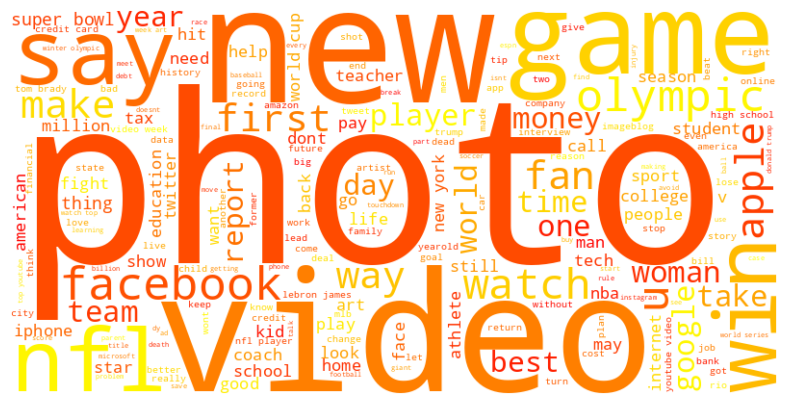

In [10]:
# word cloud visualization
from wordcloud import WordCloud  # for word cloud
txt_all = ' '.join(df['cleaned_headline'])  # combine all text
wc = WordCloud(width=800, height=400, background_color='white', colormap='autumn').generate(txt_all)  # generate word cloud
plt.figure(figsize=(10,5))  # set size
plt.imshow(wc, interpolation='bilinear')  # display image
plt.axis('off')  # hide axes
plt.show()  # show plot

1.4. Tokenization and Padding

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer  # import tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # import pad sequences
from sklearn.preprocessing import LabelEncoder  # import label encoder
from sklearn.model_selection import train_test_split  # import train/test split

In [12]:
# encode target labels
label_encoder = LabelEncoder()  # initialize encoder
y = label_encoder.fit_transform(df['category'])  # fit and transform categories

In [13]:
# split data
X_train, X_test, y_train, y_test = train_test_split(  # split into train/test
    df['cleaned_headline'], y, test_size=0.2, random_state=42)  # 80/20 split

In [14]:
# initialize tokenizer
max_vocab = 10000  # maximum vocabulary size
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')  # init tokenizer
tokenizer.fit_on_texts(X_train)  # fit on training texts

In [15]:
# convert texts to integer sequences
seq_train = tokenizer.texts_to_sequences(X_train)  # training sequences
seq_test = tokenizer.texts_to_sequences(X_test)  # testing sequences

In [16]:
# determine max sequence length at 95th percentile
seq_lengths = [len(seq) for seq in seq_train]  # list of lengths
max_len = int(np.percentile(seq_lengths, 95))  # calculate 95th percentile
print(f"\nchosen max sequence length: {max_len}")  # print max_len


chosen max sequence length: 11


In [17]:
# pad sequences to uniform length
X_train_padded = pad_sequences(seq_train, maxlen=max_len, padding='post')  # pad train
X_test_padded = pad_sequences(seq_test, maxlen=max_len, padding='post')  # pad test

**2. Model Building and Training**

2.1.  Simple RNN with a trainable Embedding layer.

In [18]:
from tensorflow.keras.models import Sequential  # import sequential model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense  # import layers

num_classes = len(label_encoder.classes_)  # number of unique categories

In [19]:
from tensorflow.keras.models import Sequential  # import sequential model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense  # import layers

num_classes = len(label_encoder.classes_)  # number of unique categories
# %%
vocab_size = 10000
embedding_dim = 32
sequence_length = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)) # Changed input_shape to input_length
model.add(SimpleRNN(64))
model.add(Dense(num_classes, activation='softmax')) # Changed output layer to handle multi-class classification

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
vocab_size = 10000
embedding_dim = 32
sequence_length = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(sequence_length,)))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,273 (1.24 MB)

 Trainable params: 326,273 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

2.2.  LSTM  LSTM with a trainable Embedding layer.


In [21]:
model2 = Sequential()  # initialize model
model2.add(Embedding(input_dim=max_vocab, output_dim=50, input_shape=(max_len,)))  # fixed input shape
model2.add(LSTM(64))  # add LSTM layer
model2.add(Dense(num_classes, activation='softmax'))  # output layer

model2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 11, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,765 (2.02 MB)

 Trainable params: 529,765 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

2.3.  LSTM with pretrained Word2Vec embeddings.

In [22]:
!pip install  scipy==1.10.1 gensim==4.3.1

In [23]:
import gensim.downloader as api  # import gensim downloader

# load word2vec-google-news-300 pretrained
w2v_model = api.load('word2vec-google-news-300')  # download and load model

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [24]:
# build embedding matrix
embedding_dim = 300  # word2vec dimension
embedding_matrix = np.zeros((max_vocab, embedding_dim))  # initialize matrix
for word, index in tokenizer.word_index.items():  # iterate vocabulary
    if index < max_vocab and word in w2v_model:  # check bounds and presence
        embedding_matrix[index] = w2v_model[word]  # assign vector

model3 = Sequential()  # initialize model
model3.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim,  # add pretrained embedding layer
                     weights=[embedding_matrix], input_length=max_len, trainable=False))  # freeze weights
model3.add(LSTM(64))  # add lstm layer
model3.add(Dense(num_classes, activation='softmax'))  # output layer

In [25]:
print("\nmodel 3 summary:")  # print summary
model3.summary()  # display summary


model 3 summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

**3. Model Training and Evaluation**

3.1.  Compile models with following configurations:
– Appropriate Loss Function.
– Appropriate optimizer.
– Appropriate Metrics.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping  # import early stopping
from sklearn.metrics import confusion_matrix, classification_report  # import metrics

In [27]:
def train_and_evaluate(model, name):  # function for training and evaluation
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # compile model
    earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # define early stopping
    hist = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[earlystop])  # train

    # plot loss and accuracy curves
    plt.figure(figsize=(12,4))  # figure size
    plt.subplot(1,2,1)  # subplot 1
    plt.plot(hist.history['loss'], label='train loss')  # train loss
    plt.plot(hist.history['val_loss'], label='val loss')  # validation loss
    plt.title(f'{name} loss over epochs')  # title
    plt.legend()  # legend
    plt.subplot(1,2,2)  # subplot 2
    plt.plot(hist.history['accuracy'], label='train acc')  # train accuracy
    plt.plot(hist.history['val_accuracy'], label='val acc')  # validation accuracy
    plt.title(f'{name} accuracy over epochs')  # title
    plt.legend()  # legend
    plt.tight_layout()  # layout
    plt.show()  # display plots

    # model evaluation
    preds = np.argmax(model.predict(X_test_padded), axis=1)  # predictions
    print(f"\n{name} classification report:")  # heading
    print(classification_report(y_test, preds))  # print metrics
    cm = confusion_matrix(y_test, preds)  # confusion matrix
    sns.heatmap(cm, annot=True, fmt='d')  # plot heatmap
    plt.title(f'{name} confusion matrix')  # title
    plt.show()  # display

# run experiments for each model

In [28]:
from tensorflow.keras.models import Sequential  # import sequential model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense  # import layers

num_classes = len(label_encoder.classes_)  # number of unique categories

vocab_size = 10000
embedding_dim = 32
sequence_length = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(SimpleRNN(64, input_shape=(sequence_length, embedding_dim)))  # Adding the input_shape parameter
model.add(Dense(num_classes, activation='softmax'))  # Changed output layer to handle multi-class classification

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5226 - loss: 1.2251 - val_accuracy: 0.7863 - val_loss: 0.6294
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8753 - loss: 0.3674 - val_accuracy: 0.8129 - val_loss: 0.5601
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9746 - loss: 0.1061 - val_accuracy: 0.7999 - val_loss: 0.7080
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9869 - loss: 0.0516 - val_accuracy: 0.7954 - val_loss: 0.8041
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9916 - loss: 0.0332 - val_accuracy: 0.7727 - val_loss: 0.8970


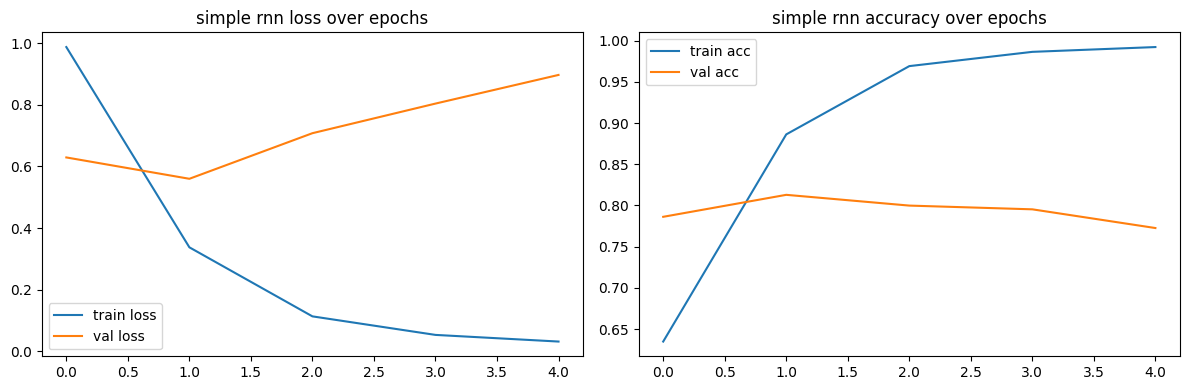

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

simple rnn classification report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       224
           1       0.67      0.68      0.68       193
           2       0.75      0.77      0.76       338
           3       0.92      0.92      0.92      1020
           4       0.78      0.76      0.77       430

    accuracy                           0.82      2205
   macro avg       0.76      0.76      0.76      2205
weighted avg       0.82      0.82      0.82      2205



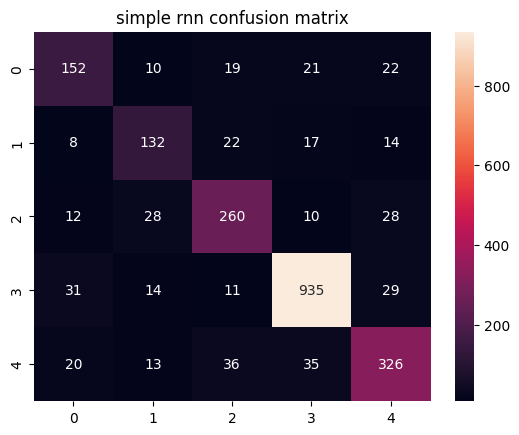

In [29]:
train_and_evaluate(model, 'simple rnn')  # simple rnn

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5007 - loss: 1.3077 - val_accuracy: 0.6480 - val_loss: 0.8544
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7379 - loss: 0.6163 - val_accuracy: 0.8322 - val_loss: 0.5128
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9390 - loss: 0.1913 - val_accuracy: 0.8231 - val_loss: 0.6168
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9779 - loss: 0.0864 - val_accuracy: 0.8243 - val_loss: 0.6479
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9880 - loss: 0.0441 - val_accuracy: 0.8254 - val_loss: 0.6940


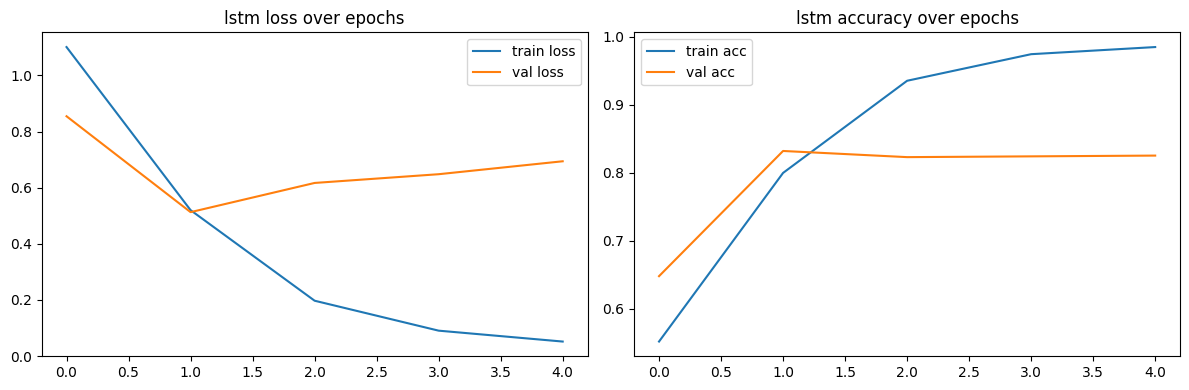

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

lstm classification report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       224
           1       0.82      0.55      0.66       193
           2       0.77      0.77      0.77       338
           3       0.88      0.96      0.92      1020
           4       0.83      0.79      0.81       430

    accuracy                           0.84      2205
   macro avg       0.81      0.76      0.78      2205
weighted avg       0.83      0.84      0.83      2205



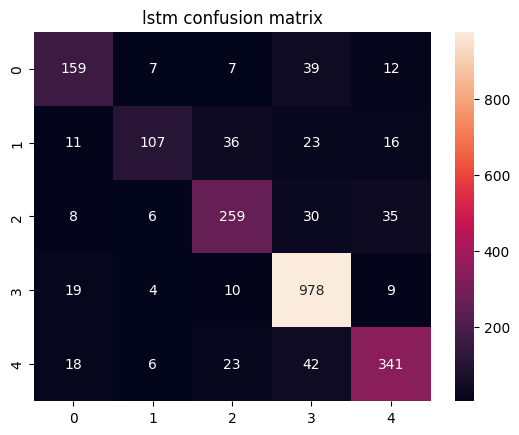

In [30]:
train_and_evaluate(model2, 'lstm')  # lstm

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6228 - loss: 0.9854 - val_accuracy: 0.8401 - val_loss: 0.4707
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8612 - loss: 0.4173 - val_accuracy: 0.8469 - val_loss: 0.4391
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8785 - loss: 0.3735 - val_accuracy: 0.8430 - val_loss: 0.4402
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8989 - loss: 0.3190 - val_accuracy: 0.8396 - val_loss: 0.4381
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9046 - loss: 0.2928 - val_accuracy: 0.8475 - val_loss: 0.4633
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9145 - loss: 0.2551 - val_accuracy: 0.8379 - val_loss: 0.4728
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9287 - loss: 0.2206 - val_accuracy: 0.8396 - val_loss: 0.4753


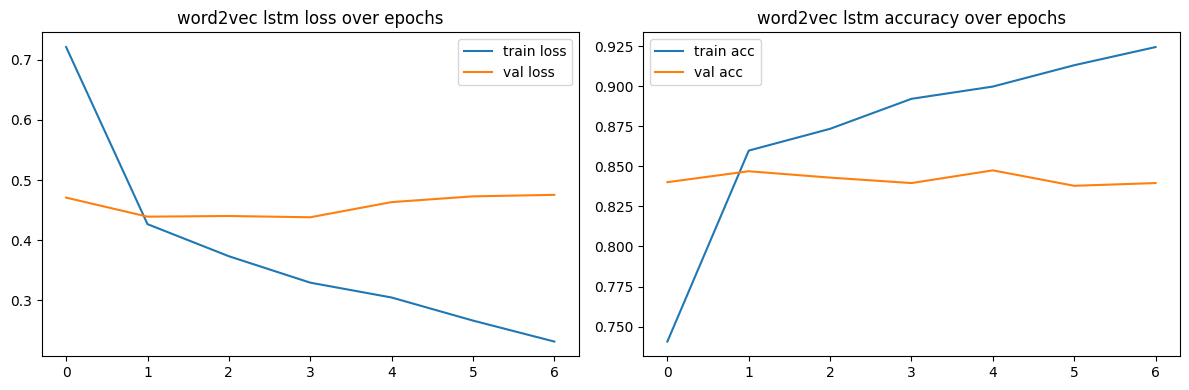

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

word2vec lstm classification report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       224
           1       0.71      0.73      0.72       193
           2       0.80      0.85      0.82       338
           3       0.93      0.92      0.92      1020
           4       0.85      0.78      0.82       430

    accuracy                           0.85      2205
   macro avg       0.80      0.82      0.81      2205
weighted avg       0.86      0.85      0.85      2205



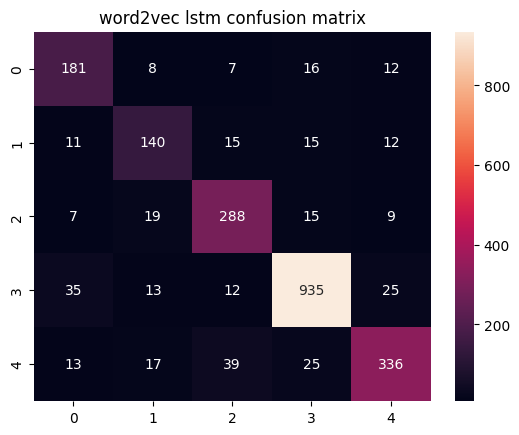

In [31]:
train_and_evaluate(model3, 'word2vec lstm')  # pretrained word2vec lstm

**4. GUI for Real Time Prediction**

4.1. Tkinter, Gradio, or Streamlit

In [32]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [33]:
import gradio as gr
def predict_category(input_text):  # prediction function
    cleaned = preprocess_text(input_text)  # clean text
    seq = tokenizer.texts_to_sequences([cleaned])  # sequence
    pad_seq = pad_sequences(seq, maxlen=max_len, padding='post')  # pad sequence
    pred = model3.predict(pad_seq)  # model prediction
    return label_encoder.inverse_transform([np.argmax(pred)])[0]  # return category

In [34]:
# launch gradio interface
gr.Interface(
    fn=predict_category,  # function
    inputs=gr.Textbox(lines=2, placeholder="enter a news headline..."),  # input widget
    outputs=gr.Textbox(label="predicted category"),  # output widget
    title="news headline category predictor",  # title
    description="predicts category using pretrained word2vec lstm model"  # description
).launch(share=True)  # share publicly

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c0b99f045827fc9db9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
